In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots

In [2]:
import pandas as pd

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
yTrain = train.Target
xTrain = train.drop(['Target','Id'], axis=1)

In [6]:
xTrain.shape

(9557, 141)

In [7]:
yTrain.value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

# Feature Engineering Module

In [8]:
train_null = xTrain.isnull().sum()
train_null[train_null != 0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

In [9]:
xTrain.rez_esc.value_counts()

0.0    1211
1.0     227
2.0      98
3.0      55
4.0      29
5.0       9
Name: rez_esc, dtype: int64

In [10]:
xTrain.rez_esc.isnull().sum()

7928

part of my code in Feature Engineering Module is credited to https://www.kaggle.com/willkoehrsen/featuretools-for-good

In [11]:
xTrain.loc[((xTrain['age'] > 19) | (xTrain['age'] < 7)) & (xTrain['rez_esc'].isnull()), 'rez_esc'] = 0
xTrain.rez_esc.fillna(xTrain.rez_esc.mean(), inplace=True)

xTrain.rez_esc.isnull().sum()

0

In [12]:
xTrain["v18q1"] = xTrain["v18q1"].fillna(0)

In [13]:
# Fill in households that own the house with 0 rent payment
xTrain.loc[(xTrain['tipovivi1'] == 1), 'v2a1'] = 0
xTrain["v2a1"].fillna(xTrain["v2a1"].mean(), inplace=True)
xTrain["meaneduc"].fillna(xTrain["meaneduc"].mean(), inplace=True)
xTrain["SQBmeaned"].fillna(xTrain["SQBmeaned"].mean(), inplace=True)

In [14]:
# Difference between people living in house and household size
xTrain['hhsize-diff'] = xTrain['tamviv'] - xTrain['hhsize']

In [15]:
xTrain['walls'] = np.argmax(np.array(xTrain[['epared1', 'epared2', 'epared3']]), axis = 1)

# Roof ordinal variable
xTrain['roof'] = np.argmax(np.array(xTrain[['etecho1', 'etecho2', 'etecho3']]), axis = 1)

# Floor ordinal variable
xTrain['floor'] = np.argmax(np.array(xTrain[['eviv1', 'eviv2', 'eviv3']]), axis = 1)

# Create new feature
xTrain['walls+roof+floor'] = xTrain['walls'] + xTrain['roof'] + xTrain['floor']

In [16]:
# No toilet, no electricity, no floor, no water service, no ceiling
xTrain['warning'] = 1 * (xTrain['sanitario1'] + 
                         xTrain['noelec'] + 
                         xTrain['pisonotiene'] + 
                         xTrain['abastaguano'] + 
                         (xTrain['cielorazo'] == 0))

In [17]:
# Owns a refrigerator, computer, tablet, and television
xTrain['bonus'] = 1 * (xTrain['refrig'] + 
                      xTrain['computer'] + 
                      (xTrain['v18q1'] > 0) + 
                      xTrain['television'])

In [18]:
# Per capita features
xTrain['phones-per-capita'] = xTrain['qmobilephone'] / xTrain['tamviv']
xTrain['tablets-per-capita'] = xTrain['v18q1'] / xTrain['tamviv']
xTrain['rooms-per-capita'] = xTrain['rooms'] / xTrain['tamviv']
xTrain['rent-per-capita'] = xTrain['v2a1'] / xTrain['tamviv']

In [19]:
xTrain['tech'] = xTrain['v18q'] + xTrain['mobilephone']

In [20]:
string_column = [f for f in xTrain.columns if xTrain.dtypes[f] == 'object']
string_column

['idhogar', 'dependency', 'edjefe', 'edjefa']

In [21]:
xTrain[string_column].head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


In [22]:
xTrain.drop(['idhogar'], axis = 1, inplace = True)

xTrain['dependency'].replace('no', 0, inplace = True)
xTrain['edjefe'].replace('no', 0, inplace = True)
xTrain['edjefa'].replace('no', 0, inplace = True)

xTrain['dependency'].replace('yes', 1, inplace = True)
xTrain['edjefe'].replace('yes', 1, inplace = True)
xTrain['edjefa'].replace('yes', 1, inplace = True)

In [23]:
xTrain[['dependency','edjefe','edjefa']].head()

,dependency,edjefe,edjefa
0,0,10,0
1,8,12,0
2,8,0,11
3,1,11,0
4,1,11,0


In [24]:
xTrain[['dependency','edjefe','edjefa']] = xTrain[['dependency','edjefe','edjefa']].apply(pd.to_numeric)

[f for f in xTrain.columns if xTrain.dtypes[f] == 'object']

[]

In [25]:
xTrain.shape

(9557, 152)

In [26]:
pd.options.mode.use_inf_as_na = True

In [27]:
# labor force
xTrain['adult'] = xTrain['hogar_adul'] - xTrain['hogar_mayor']
xTrain['dependency_count'] = xTrain['hogar_nin'] + xTrain['hogar_mayor']
xTrain['dependency2'] = xTrain['dependency_count'] / xTrain['adult']
xTrain['child_percent'] = xTrain['hogar_nin']/xTrain['hogar_total']
xTrain['elder_percent'] = xTrain['hogar_mayor']/xTrain['hogar_total']
xTrain['adult_percent'] = xTrain['hogar_adul']/xTrain['hogar_total']

In [28]:
xTrain['rent_per_adult'] = xTrain['v2a1']/xTrain['hogar_adul']
xTrain['rent_per_person'] = xTrain['v2a1']/xTrain['hhsize']

In [29]:
# male-female ratio
xTrain['r4h1_percent_in_male'] = xTrain['r4h1'] / xTrain['r4h3']
xTrain['r4m1_percent_in_female'] = xTrain['r4m1'] / xTrain['r4m3']
xTrain['r4h1_percent_in_total'] = xTrain['r4h1'] / xTrain['hhsize']
xTrain['r4m1_percent_in_total'] = xTrain['r4m1'] / xTrain['hhsize']
xTrain['r4t1_percent_in_total'] = xTrain['r4t1'] / xTrain['hhsize']

In [30]:
# per capito
xTrain['rent_per_bedroom'] = xTrain['v2a1']/xTrain['bedrooms']
xTrain['edler_per_bedroom'] = xTrain['hogar_mayor']/xTrain['bedrooms']
xTrain['adults_per_bedroom'] = xTrain['adult']/xTrain['bedrooms']
xTrain['child_per_bedroom'] = xTrain['hogar_nin']/xTrain['bedrooms']
xTrain['male_per_bedroom'] = xTrain['r4h3']/xTrain['bedrooms']
xTrain['female_per_bedroom'] = xTrain['r4m3']/xTrain['bedrooms']
xTrain['bedrooms_per_person_household'] = xTrain['hhsize']/xTrain['bedrooms']

In [31]:
train_null = xTrain.isnull().sum()
train_null[train_null != 0]

dependency2               369
rent_per_adult              5
r4h1_percent_in_male      628
r4m1_percent_in_female    328
dtype: int64

In [32]:
# when there is no adult in the house, the result will be Nan
xTrain["rent_per_adult"] = xTrain["rent_per_adult"].fillna(0)

# similar to male/female ratio
xTrain["r4h1_percent_in_male"] = xTrain["r4h1_percent_in_male"].fillna(0)
xTrain["r4m1_percent_in_female"] = xTrain["r4m1_percent_in_female"].fillna(0)

# when there is no adult in the household, the value will be inf. So, we should fill in some very large number 
xTrain.dependency2 = xTrain.dependency2.fillna(1e5)

In [35]:
train_null = xTrain.isnull().sum()
train_null[train_null != 0]

Series([], dtype: int64)

In [36]:
[f for f in xTrain.columns if xTrain.dtypes[f] == 'object']

[]

In [37]:
xTrain.shape

(9557, 172)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain,stratify=yTrain, test_size = 0.15, random_state = 2, shuffle=True)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((8123, 172), (8123,), (1434, 172), (1434,))

In [40]:
import sys, os
sys.path.append(os.pardir)  # parent directory 
from Utils.Multification_NN import *

In [41]:
Y_train = convert_to_one_hot(np.array(y_train), 5)
Y_train.shape

(5, 8123)

In [42]:
X_train = x_train.T
X_train.shape

(172, 8123)

In [43]:
Y_val = convert_to_one_hot(np.array(y_val), 5)
X_val = x_val.T
Y_val.shape, X_val.shape

((5, 1434), (172, 1434))

In [44]:
Y_train.mean(), Y_val.mean()

(0.2, 0.2)

# Training Neural Network Module

In [45]:
### CONSTANTS DEFINING THE MODEL ####
n_x = X_train.shape[0]
n_h1 = 200  # hyper parameter
n_h2 = 200  # hyper parameter
n_h3 = 100  # hyper parameter
n_y = Y_train.shape[0]
layers_dims = [n_x, n_h1, n_h2, n_h3, n_y]
layers_dims

[172, 200, 200, 100, 5]

Cost after epoch 0: 305.058369
Cost after epoch 100: 0.743039
Cost after epoch 200: 0.711185
Cost after epoch 300: 0.653392
Cost after epoch 400: 0.643338
Cost after epoch 500: 0.593690
Cost after epoch 600: 0.581654
Cost after epoch 700: 0.583279
Cost after epoch 800: 0.592613
Cost after epoch 900: 0.584582
Cost after epoch 1000: 0.573019
Cost after epoch 1100: 0.590653
Cost after epoch 1200: 0.551447
Cost after epoch 1300: 0.541190
Cost after epoch 1400: 0.552314


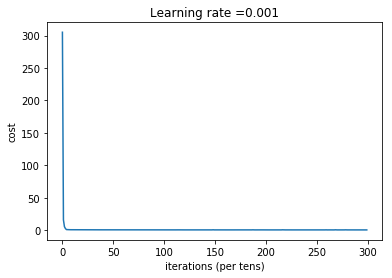

Parameters have been trained!
Train Accuracy: 0.79822725
Test Accuracy: 0.7189679


In [48]:
parameters = model(layers_dims, X_train, Y_train, X_val, Y_val, learning_rate = 0.001, reg = 0, num_epochs = 1500)

# Prediction Module

In [49]:
xTest = test.drop(['Id'], axis=1)

In [50]:
test_null = xTest.isnull().sum()
test_null[test_null != 0]

v2a1         17403
v18q1        18126
rez_esc      19653
meaneduc        31
SQBmeaned       31
dtype: int64

In [51]:
xTest["v18q1"] = xTest["v18q1"].fillna(0)

In [52]:
xTest.loc[((xTest['age'] > 19) | (xTest['age'] < 7)) & (xTest['rez_esc'].isnull()), 'rez_esc'] = 0
xTest.rez_esc.fillna(xTest.rez_esc.mean(), inplace=True)

xTest.rez_esc.isnull().sum()

0

In [53]:
# Fill in households that own the house with 0 rent payment
xTest.loc[(xTest['tipovivi1'] == 1), 'v2a1'] = 0
xTest["v2a1"].fillna(xTest["v2a1"].mean(), inplace=True)
xTest["meaneduc"].fillna(xTest["meaneduc"].mean(), inplace=True)
xTest["SQBmeaned"].fillna(xTest["SQBmeaned"].mean(), inplace=True)

In [54]:
# Difference between people living in house and household size
xTest['hhsize-diff'] = xTest['tamviv'] - xTest['hhsize']

In [55]:
xTest['walls'] = np.argmax(np.array(xTest[['epared1', 'epared2', 'epared3']]), axis = 1)

# Roof ordinal variable
xTest['roof'] = np.argmax(np.array(xTest[['etecho1', 'etecho2', 'etecho3']]), axis = 1)

# Floor ordinal variable
xTest['floor'] = np.argmax(np.array(xTest[['eviv1', 'eviv2', 'eviv3']]), axis = 1)

# Create new feature
xTest['walls+roof+floor'] = xTest['walls'] + xTest['roof'] + xTest['floor']

In [56]:
# No toilet, no electricity, no floor, no water service, no ceiling
xTest['warning'] = 1 * (xTest['sanitario1'] + 
                         xTest['noelec'] + 
                         xTest['pisonotiene'] + 
                         xTest['abastaguano'] + 
                         (xTest['cielorazo'] == 0))

In [57]:
# Owns a refrigerator, computer, tablet, and television
xTest['bonus'] = 1 * (xTest['refrig'] + 
                      xTest['computer'] + 
                      (xTest['v18q1'] > 0) + 
                      xTest['television'])

In [58]:
# Per capita features
xTest['phones-per-capita'] = xTest['qmobilephone'] / xTest['tamviv']
xTest['tablets-per-capita'] = xTest['v18q1'] / xTest['tamviv']
xTest['rooms-per-capita'] = xTest['rooms'] / xTest['tamviv']
xTest['rent-per-capita'] = xTest['v2a1'] / xTest['tamviv']

In [59]:
xTest['tech'] = xTest['v18q'] + xTest['mobilephone']

In [60]:
test_null = xTest.isnull().sum()
test_null[test_null != 0]

Series([], dtype: int64)

In [62]:
xTest = xTest.drop(['idhogar'], axis = 1)

xTest['dependency'].replace('no', 0, inplace = True)
xTest['edjefe'].replace('no', 0, inplace = True)
xTest['edjefa'].replace('no', 0, inplace = True)

xTest['dependency'].replace('yes', 1, inplace = True)
xTest['edjefe'].replace('yes', 1, inplace = True)
xTest['edjefa'].replace('yes', 1, inplace = True)

In [63]:
xTest[['dependency','edjefe','edjefa']] = xTest[['dependency','edjefe','edjefa']].apply(pd.to_numeric)

[f for f in xTest.columns if xTest.dtypes[f] == 'object']

[]

In [64]:
# labor force
xTest['adult'] = xTest['hogar_adul'] - xTest['hogar_mayor']
xTest['dependency_count'] = xTest['hogar_nin'] + xTest['hogar_mayor']
xTest['dependency2'] = xTest['dependency_count'] / xTest['adult']
xTest['child_percent'] = xTest['hogar_nin']/xTest['hogar_total']
xTest['elder_percent'] = xTest['hogar_mayor']/xTest['hogar_total']
xTest['adult_percent'] = xTest['hogar_adul']/xTest['hogar_total']

In [65]:
xTest['rent_per_adult'] = xTest['v2a1']/xTest['hogar_adul']
xTest['rent_per_person'] = xTest['v2a1']/xTest['hhsize']

In [66]:
# male-female ratio
xTest['r4h1_percent_in_male'] = xTest['r4h1'] / xTest['r4h3']
xTest['r4m1_percent_in_female'] = xTest['r4m1'] / xTest['r4m3']
xTest['r4h1_percent_in_total'] = xTest['r4h1'] / xTest['hhsize']
xTest['r4m1_percent_in_total'] = xTest['r4m1'] / xTest['hhsize']
xTest['r4t1_percent_in_total'] = xTest['r4t1'] /xTest['hhsize']

In [67]:
# per capito
xTest['rent_per_bedroom'] = xTest['v2a1']/xTest['bedrooms']
xTest['edler_per_bedroom'] = xTest['hogar_mayor']/xTest['bedrooms']
xTest['adults_per_bedroom'] = xTest['adult']/xTest['bedrooms']
xTest['child_per_bedroom'] = xTest['hogar_nin']/xTest['bedrooms']
xTest['male_per_bedroom'] = xTest['r4h3']/xTest['bedrooms']
xTest['female_per_bedroom'] = xTest['r4m3']/xTest['bedrooms']
xTest['bedrooms_per_person_household'] = xTest['hhsize']/xTest['bedrooms']

In [68]:
# when there is no adult in the house, the result will be Nan
xTest["rent_per_adult"] = xTest["rent_per_adult"].fillna(0)

# similar to male/female ratio
xTest["r4h1_percent_in_male"] = xTest["r4h1_percent_in_male"].fillna(0)
xTest["r4m1_percent_in_female"] = xTest["r4m1_percent_in_female"].fillna(0)

# when there is no adult in the household, the value will be inf. So, we should fill in some very large number 
xTest.dependency2 = xTest.dependency2.fillna(1e5)

In [69]:
test_null = xTest.isnull().sum()
test_null[test_null != 0]

Series([], dtype: int64)

In [70]:
X_test = xTest.T
X_test.shape

(172, 23856)

In [71]:
prediction = predict(X_test, parameters)
pd.Series(prediction).value_counts()

In [73]:
prediction[prediction==0] = 1

In [74]:
pd.Series(prediction).value_counts()

4    19436
2     2510
3     1191
1      719
dtype: int64

In [ ]:
test['Target'] = prediction
df2 = pd.DataFrame({'Id':test['Id'],'Target':test.Target})
df2.to_csv("submission.csv",index=False)